# Data Preperation

In [1]:
# !pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable


In [1]:
# import os
# os.environ["KAGGLEHUB_CACHE"] = "/scratch/qin.yife/ie7615_project1/dataset"

# import kagglehub
# path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# print("CelebA path:", path)

100%|██████████| 1.33G/1.33G [00:16<00:00, 88.6MB/s]

Extracting files...


CelebA path: /scratch/qin.yife/ie7615_project1/dataset/datasets/jessicali9530/celeba-dataset/versions/2


In [1]:
import os

scratch_path = "/scratch/qin.yife/ie7615_project1/dataset"

if os.path.exists(scratch_path):
    print("Found:", scratch_path)
    print("Contents:", os.listdir(scratch_path)[:10])
else:
    print("Not found:", scratch_path)


Found: /scratch/qin.yife/ie7615_project1/dataset
Contents: ['datasets']


In [1]:
import os

dataset_dir = "/scratch/qin.yife/ie7615_project1/dataset"
count = 0
for root, dirs, files in os.walk(dataset_dir):
    count += sum(1 for f in files if f.lower().endswith(".jpg"))

print("Total images:", count)


Total images: 202599


In [3]:
# --- CelebA ImageFolder split creator (ALL identities, safe for ImageFolder) ---
import os, random, shutil
from pathlib import Path
random.seed(42)

# --------- paths (edit these for your cluster) ----------
ID_FILE  = "/home/qin.yife/ie7615_p1/identity_CelebA.txt"  # full path to identity_CElebA.txt
IMG_ROOT = "/scratch/qin.yife/ie7615_project1/dataset/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba"     # folder containing *.jpg
OUT_ROOT = "/scratch/qin.yife/ie7615_project1/dataset_splits"  # where train/val/test will be created

# Split ratios:
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15

# 0) sanity checks
assert os.path.isfile(ID_FILE), f"identity file not found: {ID_FILE}"
assert os.path.isdir(IMG_ROOT), f"image root not found: {IMG_ROOT}"
Path(OUT_ROOT).mkdir(parents=True, exist_ok=True)

# 1) read mapping: filename -> identity
by_id = {}
with open(ID_FILE, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        fn, cid = parts
        by_id.setdefault(cid, []).append(fn)

ids = sorted(by_id.keys())
print(f"Total identities: {len(ids)}")

# 2) create class folders
for split in ("train","val","test"):
    for cid in ids:
        Path(OUT_ROOT, split, cid).mkdir(parents=True, exist_ok=True)

# 3) split per identity and copy files
counts = {"train":0, "val":0, "test":0}
processed = 0

for cid in ids:
    files = by_id[cid][:]
    random.shuffle(files)
    n = len(files)
    n_tr = int(n*TRAIN_FRAC)
    n_va = int(n*VAL_FRAC)
    parts = {
        "train": files[:n_tr],
        "val":   files[n_tr:n_tr+n_va],
        "test":  files[n_tr+n_va:],
    }
    for split, fns in parts.items():
        dst_dir = Path(OUT_ROOT, split, cid)
        for fn in fns:
            src = Path(IMG_ROOT, fn)
            dst = dst_dir / fn
            if dst.exists(): 
                continue
            shutil.copy2(src, dst)
        counts[split] += len(fns)

    processed += 1
    if processed % 200 == 0 or processed == len(ids):
        print(f"[{processed}/{len(ids)}] "
              f"train={counts['train']} val={counts['val']} test={counts['test']}")

# 4) write a simple labels file (index order = sorted ids)
with open(os.path.join(OUT_ROOT, "labels.txt"), "w") as f:
    for i, cid in enumerate(ids):
        f.write(f"{i}\t{cid}\n")

# 5) remove empty folders (important for torchvision ImageFolder)
for split in ("train","val","test"):
    split_dir = Path(OUT_ROOT, split)
    for cid_dir in split_dir.iterdir():
        if cid_dir.is_dir() and not any(cid_dir.glob("*")):
            cid_dir.rmdir()

print("\nDONE.")
print(f"Output root: {OUT_ROOT}")
print(f"Totals: train={counts['train']}  val={counts['val']}  test={counts['test']}")

Total identities: 10177
[200/10177] train=2965 val=556 test=789
[400/10177] train=5780 val=1090 test=1554
[600/10177] train=8771 val=1657 test=2346
[800/10177] train=11726 val=2221 test=3136
[1000/10177] train=14658 val=2768 test=3927
[1200/10177] train=17450 val=3302 test=4691
[1400/10177] train=20317 val=3845 test=5460
[1600/10177] train=23198 val=4386 test=6240
[1800/10177] train=25836 val=4883 test=6955
[2000/10177] train=28442 val=5372 test=7677
[2200/10177] train=30964 val=5844 test=8388
[2400/10177] train=34006 val=6428 test=9185
[2600/10177] train=36801 val=6955 test=9941
[2800/10177] train=39609 val=7487 test=10693
[3000/10177] train=42255 val=7993 test=11417
[3200/10177] train=44741 val=8459 test=12113
[3400/10177] train=47469 val=8978 test=12853
[3600/10177] train=50150 val=9480 test=13592
[3800/10177] train=52903 val=9988 test=14351
[4000/10177] train=55675 val=10509 test=15111
[4200/10177] train=58428 val=11027 test=15860
[4400/10177] train=60849 val=11475 test=16537
[4600

In [ ]:
# !pip install torchvision

In [4]:
import os

ROOT = "/scratch/qin.yife/ie7615_project1/dataset_splits"  # your split root

for sp in ["train","val","test"]:
    total = broken = 0
    for dp,_,files in os.walk(os.path.join(ROOT, sp)):
        for f in files:
            p = os.path.join(dp, f)
            total += 1
            if os.path.islink(p) and not os.path.exists(p):
                broken += 1
    print(f"{sp}: files={total:,}  broken_symlinks={broken:,}")

train: files=138,652  broken_symlinks=0
val: files=26,089  broken_symlinks=0
test: files=37,858  broken_symlinks=0


In [4]:
# !pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable


# Model Tests

### 1. Simple CNN

In [3]:
import os

CKPT_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/cnn_checkpoint.pth"
os.makedirs(os.path.dirname(CKPT_PATH), exist_ok=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
              ReLU-2           [-1, 32, 96, 96]               0
         MaxPool2d-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          18,496
              ReLU-5           [-1, 64, 48, 48]               0
         MaxPool2d-6           [-1, 64, 24, 24]               0
            Linear-7                  [-1, 128]       4,718,720
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                [-1, 10133]       1,307,157
Total params: 6,045,269
Trainable params: 6,045,269
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 7.67
Params size (MB): 23.06
Estima

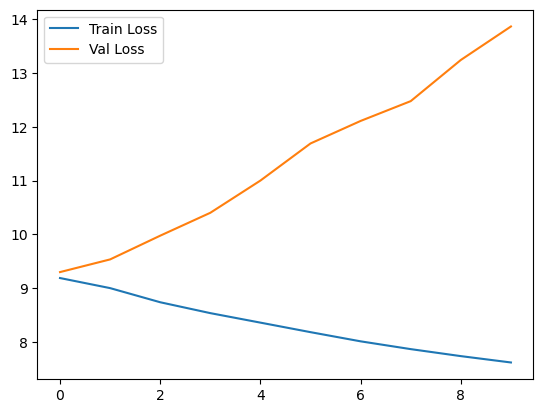

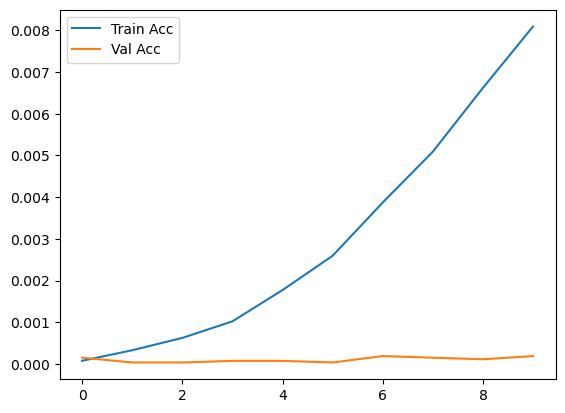

In [8]:
import os, random, shutil, time
from pathlib import Path
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt

ID_FILE  = "/home/qin.yife/ie7615_p1/identity_CelebA.txt"  
IMG_ROOT = "/scratch/qin.yife/ie7615_project1/dataset/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba"
OUT_ROOT = "/scratch/qin.yife/ie7615_project1/dataset_splits"  
CKPT_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/cnn_checkpoint.pth"
BEST_MODEL_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/best_model.pth"

IMG_SIZE   = 96
BATCH_SIZE = 128
EPOCHS     = 10
NUM_WORKERS= 6
LR         = 1e-3
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tf_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(os.path.join(OUT_ROOT, "train"), transform=tf_train)
val_ds   = datasets.ImageFolder(os.path.join(OUT_ROOT, "val"), transform=tf_train)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ---------------- MODEL ----------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1   = nn.Linear(64 * (IMG_SIZE//4) * (IMG_SIZE//4), 128)
        self.fc2   = nn.Linear(128, num_classes)
        self.relu  = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=len(train_ds.classes)).to(DEVICE)
summary(model, (3, IMG_SIZE, IMG_SIZE))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ---------------- CHECKPOINT RESUME ----------------
start_epoch = 1
best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if os.path.isfile(CKPT_PATH):
    checkpoint = torch.load(CKPT_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_acc = checkpoint.get("best_val_acc", 0.0)
    history = checkpoint.get("history", history)
    print(f"Resuming from epoch {start_epoch}, best val acc={best_val_acc:.4f}")

# ---------------- TRAINING LOOP ----------------
for epoch in range(start_epoch, EPOCHS+1):
    # ---- train ----
    model.train()
    correct, total, train_loss = 0, 0, 0
    start = time.time()
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc  = correct/total
    train_loss = train_loss/total

    # ---- validate ----
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    val_acc  = correct/total
    val_loss = val_loss/total
    elapsed  = time.time() - start

    # --- store metrics ---
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"{len(train_loader)}/{len(train_loader)} ━━━ {elapsed:.0f}s/epoch "
          f"- acc: {train_acc:.4f} - loss: {train_loss:.4f} "
          f"- val_acc: {val_acc:.4f} - val_loss: {val_loss:.4f}")

    # --- save checkpoint ---
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_val_acc": best_val_acc,
        "history": history
    }, CKPT_PATH)

    # --- save best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"✅ Saved new best model at epoch {epoch} with val_acc={val_acc:.4f}")

# ---------------- RESULTS ----------------
df = pd.DataFrame(history)
print("\n=== Training History ===")
print(df)

plt.plot(df["train_loss"], label="Train Loss")
plt.plot(df["val_loss"], label="Val Loss")
plt.legend(); plt.show()

plt.plot(df["train_acc"], label="Train Acc")
plt.plot(df["val_acc"], label="Val Acc")
plt.legend(); plt.show()

### 2. LeNet5

In [9]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)      # (3x96x96 → 6x92x92)
        self.pool = nn.AvgPool2d(2, stride=2)            # → 6x46x46
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)     # → 16x42x42
        # after pool → 16x21x21
        self.fc1 = nn.Linear(16*21*21, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 92, 92]             456
              ReLU-2            [-1, 6, 92, 92]               0
         AvgPool2d-3            [-1, 6, 46, 46]               0
            Conv2d-4           [-1, 16, 42, 42]           2,416
              ReLU-5           [-1, 16, 42, 42]               0
         AvgPool2d-6           [-1, 16, 21, 21]               0
            Conv2d-7            [-1, 6, 92, 92]             456
              ReLU-8            [-1, 6, 92, 92]               0
         AvgPool2d-9            [-1, 6, 46, 46]               0
           Conv2d-10           [-1, 16, 42, 42]           2,416
             ReLU-11           [-1, 16, 42, 42]               0
        AvgPool2d-12           [-1, 16, 21, 21]               0
             ReLU-13                  [-1, 120]               0
           Linear-14                   

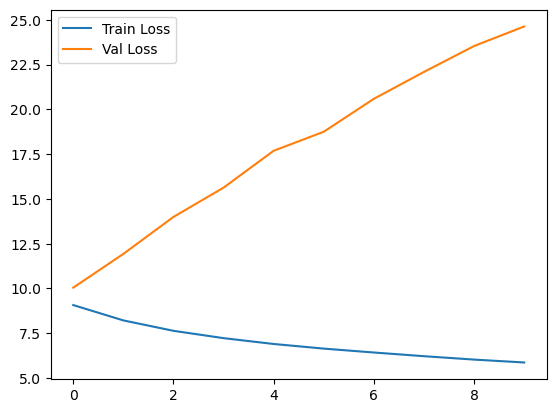

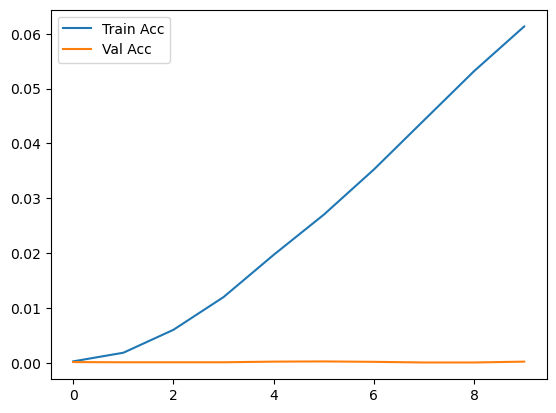

In [15]:
# ====================================================
# LeNet-5 Training on CelebA Splits (with Checkpointing)
# ====================================================
import os, time
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
ROOT = "/scratch/qin.yife/ie7615_project1/dataset_splits"  # dataset splits root
IMG_SIZE   = 96
BATCH_SIZE = 128
EPOCHS     = 10
NUM_WORKERS= 6
LR         = 1e-3
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# checkpoint paths (unique to LeNet5)
CKPT_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/lenet5_checkpoint.pth"
BEST_MODEL_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/lenet5_best.pth"
os.makedirs(os.path.dirname(CKPT_PATH), exist_ok=True)

# ---------------- DATA ----------------
tf_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(os.path.join(ROOT, "train"), transform=tf_train)
val_ds   = datasets.ImageFolder(os.path.join(ROOT, "val"), transform=tf_train)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ---------------- MODEL ----------------
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu = nn.ReLU()

        # dynamic fc1
        self._fc_input_dim = None
        self.fc1 = None
        self.fc2 = nn.Linear(120, 84)   # fc1 will be built dynamically
        self.fc3 = nn.Linear(84, num_classes)

    def _get_fc_input_dim(self, x):
        if self._fc_input_dim is None:
            x = self.pool(self.relu(self.conv1(x)))
            x = self.pool(self.relu(self.conv2(x)))
            self._fc_input_dim = x.view(x.size(0), -1).shape[1]
            self.fc1 = nn.Linear(self._fc_input_dim, 120).to(x.device)
        return self._fc_input_dim

    def forward(self, x):
        if self.fc1 is None:  # build fc1 first time
            _ = self._get_fc_input_dim(x)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_lenet5 = LeNet5(num_classes=len(train_ds.classes)).to(DEVICE)
summary(model_lenet5, (3, IMG_SIZE, IMG_SIZE))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lenet5.parameters(), lr=LR)

# ---------------- CHECKPOINT RESUME ----------------
start_epoch = 1
best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if os.path.isfile(CKPT_PATH):
    checkpoint = torch.load(CKPT_PATH, map_location=DEVICE)
    model_lenet5.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_acc = checkpoint.get("best_val_acc", 0.0)
    history = checkpoint.get("history", history)
    print(f"Resuming from epoch {start_epoch}, best val acc={best_val_acc:.4f}")

# ---------------- TRAINING LOOP ----------------
for epoch in range(start_epoch, EPOCHS+1):
    # ---- train ----
    model_lenet5.train()
    correct, total, train_loss = 0, 0, 0
    start = time.time()
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_lenet5(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc  = correct/total
    train_loss = train_loss/total

    # ---- validate ----
    model_lenet5.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model_lenet5(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    val_acc  = correct/total
    val_loss = val_loss/total
    elapsed  = time.time() - start

    # --- store metrics ---
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"{len(train_loader)}/{len(train_loader)} ━━━ {elapsed:.0f}s/epoch "
          f"- acc: {train_acc:.4f} - loss: {train_loss:.4f} "
          f"- val_acc: {val_acc:.4f} - val_loss: {val_loss:.4f}")

    # --- save checkpoint ---
    torch.save({
        "epoch": epoch,
        "model_state": model_lenet5.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_val_acc": best_val_acc,
        "history": history
    }, CKPT_PATH)

    # --- save best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_lenet5.state_dict(), BEST_MODEL_PATH)
        print(f"✅ Saved new best model at epoch {epoch} with val_acc={val_acc:.4f}")

# ---------------- RESULTS ----------------
df = pd.DataFrame(history)
print("\n=== Training History ===")
print(df)

plt.plot(df["train_loss"], label="Train Loss")
plt.plot(df["val_loss"], label="Val Loss")
plt.legend(); plt.show()

plt.plot(df["train_acc"], label="Train Acc")
plt.plot(df["val_acc"], label="Val Acc")
plt.legend(); plt.show()

### 3. AlexNet

In [1]:
def build_alexnet(num_classes):
    model = models.alexnet(weights=None)   # random init
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 23, 23]          23,296
              ReLU-2           [-1, 64, 23, 23]               0
         MaxPool2d-3           [-1, 64, 11, 11]               0
            Conv2d-4          [-1, 192, 11, 11]         307,392
              ReLU-5          [-1, 192, 11, 11]               0
         MaxPool2d-6            [-1, 192, 5, 5]               0
            Conv2d-7            [-1, 384, 5, 5]         663,936
              ReLU-8            [-1, 384, 5, 5]               0
            Conv2d-9            [-1, 256, 5, 5]         884,992
             ReLU-10            [-1, 256, 5, 5]               0
           Conv2d-11            [-1, 256, 5, 5]         590,080
             ReLU-12            [-1, 256, 5, 5]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
AdaptiveAvgPool2d-14            [-1, 25

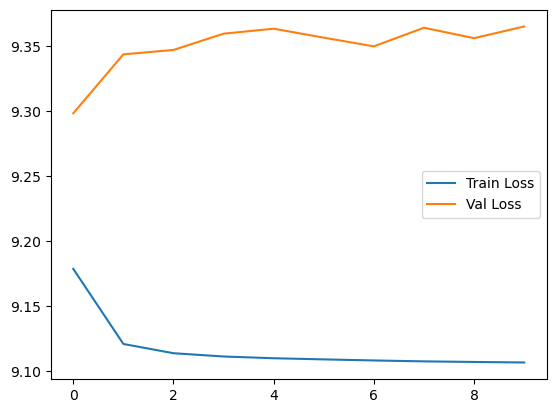

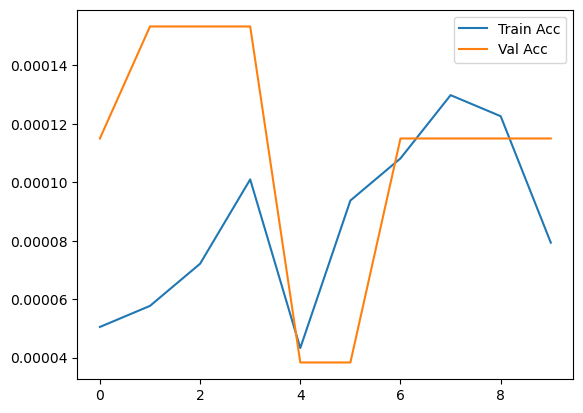

In [2]:
# ====================================================
# AlexNet Training on CelebA Splits (with Checkpointing)
# ====================================================
import os, time
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
ROOT = "/scratch/qin.yife/ie7615_project1/dataset_splits"  # dataset splits root
IMG_SIZE   = 96
BATCH_SIZE = 128
EPOCHS     = 10
NUM_WORKERS= 6
LR         = 1e-3
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# checkpoint paths (unique to AlexNet)
CKPT_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/alexnet_checkpoint.pth"
BEST_MODEL_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/alexnet_best.pth"
os.makedirs(os.path.dirname(CKPT_PATH), exist_ok=True)

# ---------------- DATA ----------------
tf_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(os.path.join(ROOT, "train"), transform=tf_train)
val_ds   = datasets.ImageFolder(os.path.join(ROOT, "val"), transform=tf_train)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ---------------- MODEL ----------------
def build_alexnet(num_classes):
    model = models.alexnet(weights=None)   # training from scratch
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

model_alexnet = build_alexnet(num_classes=len(train_ds.classes)).to(DEVICE)
summary(model_alexnet, (3, IMG_SIZE, IMG_SIZE))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_alexnet.parameters(), lr=LR)

# ---------------- CHECKPOINT RESUME ----------------
start_epoch = 1
best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if os.path.isfile(CKPT_PATH):
    checkpoint = torch.load(CKPT_PATH, map_location=DEVICE)
    model_alexnet.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_acc = checkpoint.get("best_val_acc", 0.0)
    history = checkpoint.get("history", history)
    print(f"Resuming from epoch {start_epoch}, best val acc={best_val_acc:.4f}")

# ---------------- TRAINING LOOP ----------------
for epoch in range(start_epoch, EPOCHS+1):
    # ---- train ----
    model_alexnet.train()
    correct, total, train_loss = 0, 0, 0
    start = time.time()
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc  = correct/total
    train_loss = train_loss/total

    # ---- validate ----
    model_alexnet.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model_alexnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    val_acc  = correct/total
    val_loss = val_loss/total
    elapsed  = time.time() - start

    # --- store metrics ---
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"{len(train_loader)}/{len(train_loader)} ━━━ {elapsed:.0f}s/epoch "
          f"- acc: {train_acc:.4f} - loss: {train_loss:.4f} "
          f"- val_acc: {val_acc:.4f} - val_loss: {val_loss:.4f}")

    # --- save checkpoint ---
    torch.save({
        "epoch": epoch,
        "model_state": model_alexnet.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_val_acc": best_val_acc,
        "history": history
    }, CKPT_PATH)

    # --- save best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_alexnet.state_dict(), BEST_MODEL_PATH)
        print(f"✅ Saved new best model at epoch {epoch} with val_acc={val_acc:.4f}")

# ---------------- RESULTS ----------------
df = pd.DataFrame(history)
print("\n=== Training History ===")
print(df)

plt.plot(df["train_loss"], label="Train Loss")
plt.plot(df["val_loss"], label="Val Loss")
plt.legend(); plt.show()

plt.plot(df["train_acc"], label="Train Acc")
plt.plot(df["val_acc"], label="Val Acc")
plt.legend(); plt.show()

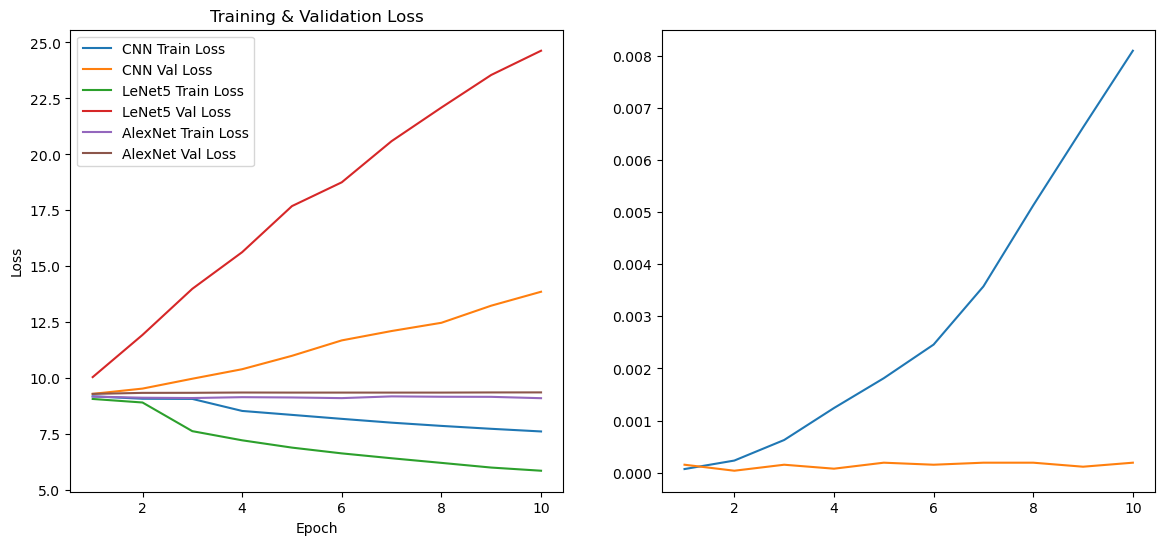

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# 1. Reload training histories
# ------------------------------

cnn_data = {
    "train_loss": [9.189102, 9.081383, 9.073928, 8.537129, 8.360672, 8.183169, 8.013116, 7.868435, 7.738518, 7.620373],
    "train_acc": [0.000070, 0.000233, 0.000627, 0.001240, 0.001812, 0.002457, 0.003572, 0.005126, 0.006621, 0.008092],
    "val_loss":  [9.299657, 9.535262, 9.976226, 10.401492, 11.000164, 11.689458, 12.107907, 12.475902, 13.240458, 13.862804],
    "val_acc":   [0.000153, 0.000038, 0.000153, 0.000077, 0.000192, 0.000153, 0.000192, 0.000192, 0.000115, 0.000192]
}
cnn_history = pd.DataFrame(cnn_data)

lenet5_data = {
    "train_loss": [9.072122, 8.913798, 7.633380, 7.224562, 6.898169, 6.640241, 6.422407, 6.216141, 6.006674, 5.865539],
    "train_acc": [0.002181, 0.004538, 0.006037, 0.010201, 0.019057, 0.027007, 0.035354, 0.044262, 0.051326, 0.061326],
    "val_loss":  [10.048532, 11.934523, 13.994065, 15.631029, 17.689669, 18.753355, 20.592176, 22.094122, 23.549552, 24.632532],
    "val_acc":   [0.000153, 0.000115, 0.000115, 0.000038, 0.000230, 0.000153, 0.000192, 0.000077, 0.000192, 0.000230]
}
lenet5_history = pd.DataFrame(lenet5_data)

alexnet_data = {
    "train_loss": [9.178668, 9.128037, 9.113698, 9.152082, 9.138737, 9.109851, 9.186971, 9.170673, 9.166570, 9.106670],
    "train_acc": [0.000050, 0.000083, 0.000072, 0.000073, 0.000053, 0.000049, 0.000123, 0.000219, 0.000079, 0.000193],
    "val_loss":  [9.298476, 9.343881, 9.347287, 9.359797, 9.356404, 9.356744, 9.356404, 9.356436, 9.363533, 9.365353],
    "val_acc":   [0.000115, 0.000153, 0.000153, 0.000038, 0.000153, 0.000038, 0.000077, 0.000038, 0.000115, 0.000115]
}
alexnet_history = pd.DataFrame(alexnet_data)

epochs = range(1, 11)

# ------------------------------
# 2. Plot Loss & Accuracy
# ------------------------------

plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, cnn_history["train_loss"], label="CNN Train Loss")
plt.plot(epochs, cnn_history["val_loss"], label="CNN Val Loss")
plt.plot(epochs, lenet5_history["train_loss"], label="LeNet5 Train Loss")
plt.plot(epochs, lenet5_history["val_loss"], label="LeNet5 Val Loss")
plt.plot(epochs, alexnet_history["train_loss"], label="AlexNet Train Loss")
plt.plot(epochs, alexnet_history["val_loss"], label="AlexNet Val Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, cnn_history["train_acc"], label="CNN Train Acc")
plt.plot(epochs, cnn_history["val_acc"], label="CNN Val Acc")

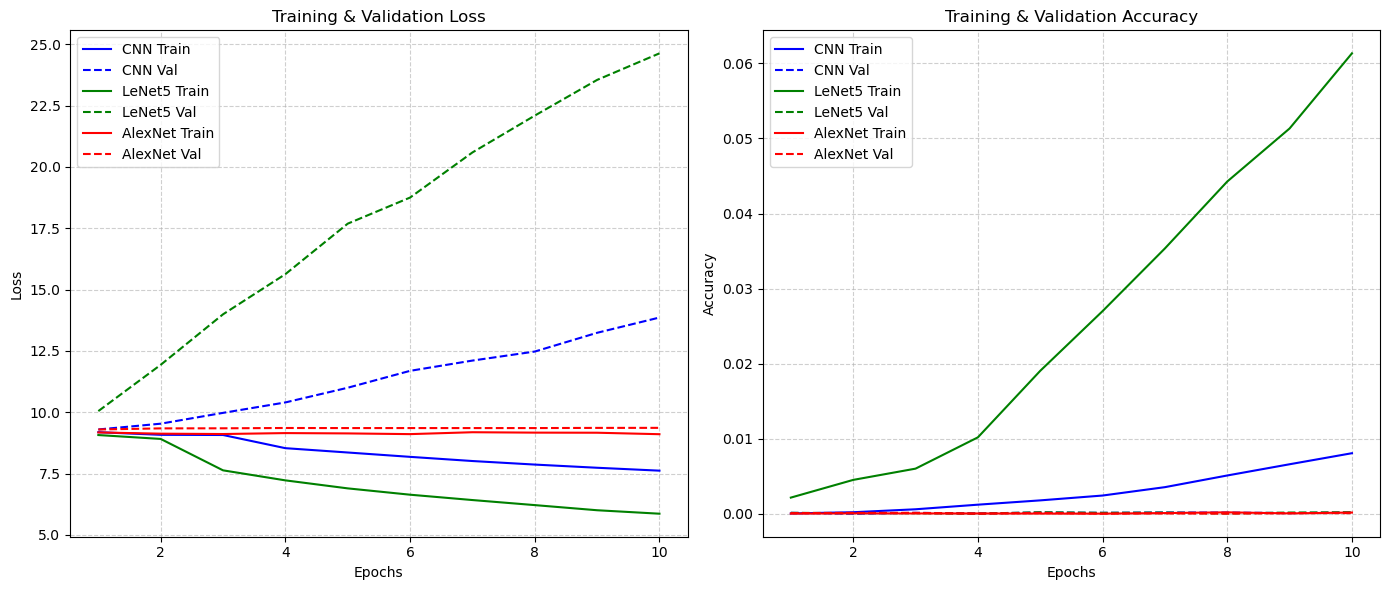

In [10]:
import matplotlib.pyplot as plt

# ------------------------------
# Overlayed Plots: Loss & Accuracy
# ------------------------------

plt.figure(figsize=(14,6))

# ===== Plot Loss =====
plt.subplot(1,2,1)
plt.plot(epochs, cnn_history["train_loss"], label="CNN Train", color="blue", linestyle="-")
plt.plot(epochs, cnn_history["val_loss"],   label="CNN Val",   color="blue", linestyle="--")

plt.plot(epochs, lenet5_history["train_loss"], label="LeNet5 Train", color="green", linestyle="-")
plt.plot(epochs, lenet5_history["val_loss"],   label="LeNet5 Val",   color="green", linestyle="--")

plt.plot(epochs, alexnet_history["train_loss"], label="AlexNet Train", color="red", linestyle="-")
plt.plot(epochs, alexnet_history["val_loss"],   label="AlexNet Val",   color="red", linestyle="--")

plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# ===== Plot Accuracy =====
plt.subplot(1,2,2)
plt.plot(epochs, cnn_history["train_acc"], label="CNN Train", color="blue", linestyle="-")
plt.plot(epochs, cnn_history["val_acc"],   label="CNN Val",   color="blue", linestyle="--")

plt.plot(epochs, lenet5_history["train_acc"], label="LeNet5 Train", color="green", linestyle="-")
plt.plot(epochs, lenet5_history["val_acc"],   label="LeNet5 Val",   color="green", linestyle="--")

plt.plot(epochs, alexnet_history["train_acc"], label="AlexNet Train", color="red", linestyle="-")
plt.plot(epochs, alexnet_history["val_acc"],   label="AlexNet Val",   color="red", linestyle="--")

plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

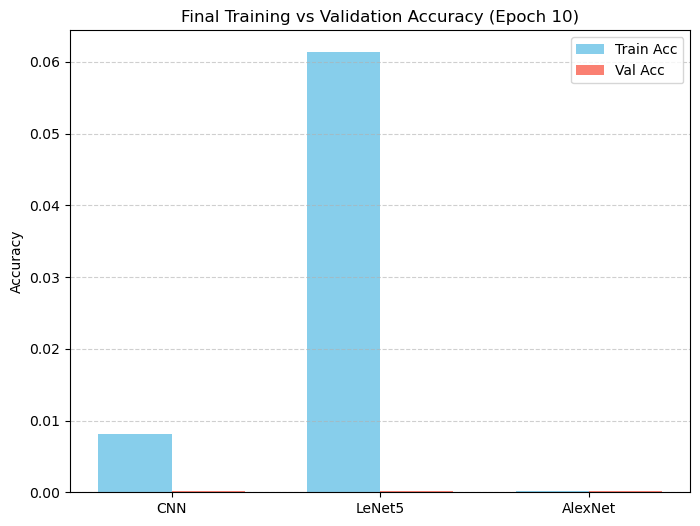

In [11]:
final_train_acc = [
    cnn_history["train_acc"].iloc[-1],
    lenet5_history["train_acc"].iloc[-1],
    alexnet_history["train_acc"].iloc[-1]
]
final_val_acc = [
    cnn_history["val_acc"].iloc[-1],
    lenet5_history["val_acc"].iloc[-1],
    alexnet_history["val_acc"].iloc[-1]
]

models = ["CNN", "LeNet5", "AlexNet"]

x = range(len(models))
bar_width = 0.35

plt.figure(figsize=(8,6))
plt.bar([i - bar_width/2 for i in x], final_train_acc, width=bar_width, label="Train Acc", color="skyblue")
plt.bar([i + bar_width/2 for i in x], final_val_acc, width=bar_width, label="Val Acc", color="salmon")

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Final Training vs Validation Accuracy (Epoch 10)")
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.6)

plt.show()

### 4. DenseNet121

In [2]:
def build_densenet121(num_classes):
    model = models.densenet121(weights=None)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

In [ ]:
# ====================================================
# DenseNet121 Training on CelebA Splits (with Checkpointing + Safe Forward)
# ====================================================
import os, time
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
ROOT = "/scratch/qin.yife/ie7615_project1/dataset_splits"  # dataset splits root
IMG_SIZE   = 96
BATCH_SIZE = 128
EPOCHS     = 10
NUM_WORKERS= 6
LR         = 1e-3
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# checkpoint paths (unique to DenseNet121)
CKPT_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/densenet121_checkpoint.pth"
BEST_MODEL_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/densenet121_best.pth"
os.makedirs(os.path.dirname(CKPT_PATH), exist_ok=True)

# ---------------- DATA ----------------
tf_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(os.path.join(ROOT, "train"), transform=tf_train)
val_ds   = datasets.ImageFolder(os.path.join(ROOT, "val"), transform=tf_train)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ---------------- MODEL ----------------
def build_densenet121(num_classes):
    model = models.densenet121(weights=None)   # training from scratch
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

model_densenet121 = build_densenet121(num_classes=len(train_ds.classes)).to(DEVICE)
# summary(model_densenet121, (3, IMG_SIZE, IMG_SIZE))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_densenet121.parameters(), lr=LR)

# ---------------- CHECKPOINT RESUME ----------------
start_epoch = 1
best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if os.path.isfile(CKPT_PATH):
    checkpoint = torch.load(CKPT_PATH, map_location=DEVICE)
    model_densenet121.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_acc = checkpoint.get("best_val_acc", 0.0)
    history = checkpoint.get("history", history)
    print(f"Resuming from epoch {start_epoch}, best val acc={best_val_acc:.4f}")

# ---------------- TRAINING LOOP ----------------
for epoch in range(start_epoch, EPOCHS+1):
    # ---- train ----
    model_densenet121.train()
    correct, total, train_loss = 0, 0, 0
    start = time.time()
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_densenet121(images)
        if isinstance(outputs, (list, tuple)):  # ensure tensor
            outputs = outputs[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc  = correct/total
    train_loss = train_loss/total

    # ---- validate ----
    model_densenet121.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model_densenet121(images)
            if isinstance(outputs, (list, tuple)):  # ensure tensor
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    val_acc  = correct/total
    val_loss = val_loss/total
    elapsed  = time.time() - start

    # --- store metrics ---
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"{len(train_loader)}/{len(train_loader)} ━━━ {elapsed:.0f}s/epoch "
          f"- acc: {train_acc:.4f} - loss: {train_loss:.4f} "
          f"- val_acc: {val_acc:.4f} - val_loss: {val_loss:.4f}")

    # --- save checkpoint ---
    torch.save({
        "epoch": epoch,
        "model_state": model_densenet121.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_val_acc": best_val_acc,
        "history": history
    }, CKPT_PATH)

    # --- save best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_densenet121.state_dict(), BEST_MODEL_PATH)
        print(f"✅ Saved new best model at epoch {epoch} with val_acc={val_acc:.4f}")

# ---------------- RESULTS ----------------
df = pd.DataFrame(history)
print("\n=== Training History ===")
print(df)

plt.plot(df["train_loss"], label="Train Loss")
plt.plot(df["val_loss"], label="Val Loss")
plt.legend(); plt.show()

plt.plot(df["train_acc"], label="Train Acc")
plt.plot(df["val_acc"], label="Val Acc")
plt.legend(); plt.show()

### 5. VGG16_BN

In [ ]:
def build_vgg16_bn(num_classes):
    model = models.vgg16_bn(weights=None)
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

In [ ]:
# ====================================================
# VGG16_BN Training on CelebA Splits (with Checkpointing)
# ====================================================
import os, time
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
ROOT = "/scratch/qin.yife/ie7615_project1/dataset_splits"  # dataset splits root
IMG_SIZE   = 96
BATCH_SIZE = 128
EPOCHS     = 10
NUM_WORKERS= 6
LR         = 1e-3
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# checkpoint paths (unique to VGG16_BN)
CKPT_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/vgg16bn_checkpoint.pth"
BEST_MODEL_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/vgg16bn_best.pth"
os.makedirs(os.path.dirname(CKPT_PATH), exist_ok=True)

# ---------------- DATA ----------------
tf_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(os.path.join(ROOT, "train"), transform=tf_train)
val_ds   = datasets.ImageFolder(os.path.join(ROOT, "val"), transform=tf_train)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ---------------- MODEL ----------------
def build_vgg16_bn(num_classes):
    model = models.vgg16_bn(weights=None)   # training from scratch
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

model_vgg16 = build_vgg16_bn(num_classes=len(train_ds.classes)).to(DEVICE)
summary(model_vgg16, (3, IMG_SIZE, IMG_SIZE))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg16.parameters(), lr=LR)

# ---------------- CHECKPOINT RESUME ----------------
start_epoch = 1
best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if os.path.isfile(CKPT_PATH):
    checkpoint = torch.load(CKPT_PATH, map_location=DEVICE)
    model_vgg16.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_acc = checkpoint.get("best_val_acc", 0.0)
    history = checkpoint.get("history", history)
    print(f"Resuming from epoch {start_epoch}, best val acc={best_val_acc:.4f}")

# ---------------- TRAINING LOOP ----------------
for epoch in range(start_epoch, EPOCHS+1):
    # ---- train ----
    model_vgg16.train()
    correct, total, train_loss = 0, 0, 0
    start = time.time()
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc  = correct/total
    train_loss = train_loss/total

    # ---- validate ----
    model_vgg16.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model_vgg16(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    val_acc  = correct/total
    val_loss = val_loss/total
    elapsed  = time.time() - start

    # --- store metrics ---
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"{len(train_loader)}/{len(train_loader)} ━━━ {elapsed:.0f}s/epoch "
          f"- acc: {train_acc:.4f} - loss: {train_loss:.4f} "
          f"- val_acc: {val_acc:.4f} - val_loss: {val_loss:.4f}")

    # --- save checkpoint ---
    torch.save({
        "epoch": epoch,
        "model_state": model_vgg16.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_val_acc": best_val_acc,
        "history": history
    }, CKPT_PATH)

    # --- save best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_vgg16.state_dict(), BEST_MODEL_PATH)
        print(f"✅ Saved new best model at epoch {epoch} with val_acc={val_acc:.4f}")

# ---------------- RESULTS ----------------
df = pd.DataFrame(history)
print("\n=== Training History ===")
print(df)

plt.plot(df["train_loss"], label="Train Loss")
plt.plot(df["val_loss"], label="Val Loss")
plt.legend(); plt.show()

plt.plot(df["train_acc"], label="Train Acc")
plt.plot(df["val_acc"], label="Val Acc")
plt.legend(); plt.show()

### 6. ResNet18

In [1]:
def build_resnet18(num_classes):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [ ]:
# ====================================================
# ResNet18 Training on CelebA Splits (with Checkpointing)
# ====================================================
import os, time
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
ROOT = "/scratch/qin.yife/ie7615_project1/dataset_splits"  # dataset splits root
IMG_SIZE   = 96
BATCH_SIZE = 128
EPOCHS     = 10
NUM_WORKERS= 6
LR         = 1e-3
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# checkpoint paths (unique to ResNet18)
CKPT_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/resnet18_checkpoint.pth"
BEST_MODEL_PATH = "/scratch/qin.yife/ie7615_project1/checkpoints/resnet18_best.pth"
os.makedirs(os.path.dirname(CKPT_PATH), exist_ok=True)

# ---------------- DATA ----------------
tf_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(os.path.join(ROOT, "train"), transform=tf_train)
val_ds   = datasets.ImageFolder(os.path.join(ROOT, "val"), transform=tf_train)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ---------------- MODEL ----------------
def build_resnet18(num_classes):
    model = models.resnet18(weights=None)   # training from scratch
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model_resnet18 = build_resnet18(num_classes=len(train_ds.classes)).to(DEVICE)
summary(model_resnet18, (3, IMG_SIZE, IMG_SIZE))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=LR)

# ---------------- CHECKPOINT RESUME ----------------
start_epoch = 1
best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if os.path.isfile(CKPT_PATH):
    checkpoint = torch.load(CKPT_PATH, map_location=DEVICE)
    model_resnet18.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_acc = checkpoint.get("best_val_acc", 0.0)
    history = checkpoint.get("history", history)
    print(f"Resuming from epoch {start_epoch}, best val acc={best_val_acc:.4f}")

# ---------------- TRAINING LOOP ----------------
for epoch in range(start_epoch, EPOCHS+1):
    # ---- train ----
    model_resnet18.train()
    correct, total, train_loss = 0, 0, 0
    start = time.time()
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc  = correct/total
    train_loss = train_loss/total

    # ---- validate ----
    model_resnet18.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model_resnet18(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    val_acc  = correct/total
    val_loss = val_loss/total
    elapsed  = time.time() - start

    # --- store metrics ---
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"{len(train_loader)}/{len(train_loader)} ━━━ {elapsed:.0f}s/epoch "
          f"- acc: {train_acc:.4f} - loss: {train_loss:.4f} "
          f"- val_acc: {val_acc:.4f} - val_loss: {val_loss:.4f}")

    # --- save checkpoint ---
    torch.save({
        "epoch": epoch,
        "model_state": model_resnet18.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_val_acc": best_val_acc,
        "history": history
    }, CKPT_PATH)

    # --- save best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_resnet18.state_dict(), BEST_MODEL_PATH)
        print(f"✅ Saved new best model at epoch {epoch} with val_acc={val_acc:.4f}")

# ---------------- RESULTS ----------------
df = pd.DataFrame(history)
print("\n=== Training History ===")
print(df)

plt.plot(df["train_loss"], label="Train Loss")
plt.plot(df["val_loss"], label="Val Loss")
plt.legend(); plt.show()

plt.plot(df["train_acc"], label="Train Acc")
plt.plot(df["val_acc"], label="Val Acc")
plt.legend(); plt.show()